# Tests with models controlling acceleration instead of speed

## Single agent with acceleration control

Built on the single speed-controlling agent model in [First simple tests](../first simple tests/First simple test.ipynb), but modifying such that step-wise adjustments are not applied to speed $v$ and heading $\psi$ directly, but instead to longitudinal acceleration $a$ and to a steering angle $\delta$, which generates yaw rates $\omega$ with a simplified lateral dynamics model $\omega = K_s v \delta$. In other words, instead of controlling speed and heading directly, the agent operates on longitudinal and rotational accelerations, like a driver does. Also increasing the adjustment duration to $\Delta T$ = 0.5 s, to be a little more driving-like (taking into account also vehicle dynamics delays).

Extending the value function to:

$V = -k_g v_g - k_o \sum_i 1 / \tau_i - C_v v^2 - C_a a^2 - C_{\omega} (v/\omega)^2 - C_p \Delta a^2 - C_t \Delta \delta^2 - C_g a_g^2$

where the first three terms work in the same way as in the speed-controlling model. The logic of the $C_{\omega}$ term is that $v/\omega$ is lateral acceleration, i.e., this is a lateral acceleration discomfort term, analogous to the longitudinal acceleration discomfort term just before it. Then follow two terms with effort costs for applying acceleration and steering angle adjustments $\Delta a$ and $\Delta \delta$.

The final value function term is a cost for experiencing a high required acceleration $a_g$ for stopping at the goal. If the agent is heading straight toward the goal, trivially $a_g = -v^2 / 2 d_g$, where $d_g$ is the distance to the goal. The current implementation instead uses the distance $d_g'$ to the point where the agent will be passing the goal, i.e., when $v_g$ will pass zero and turn negative (which reduces to the above expression when the heading is straight toward the goal).

Below it can be seen that it sort of works:


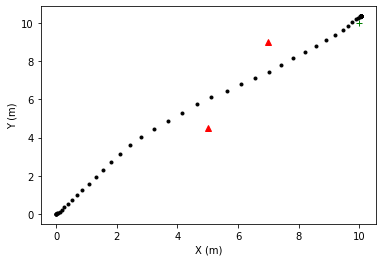

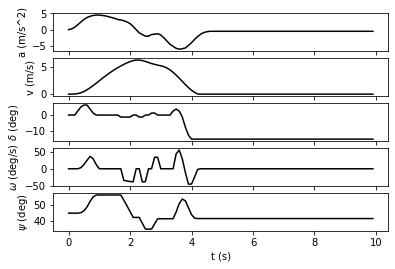

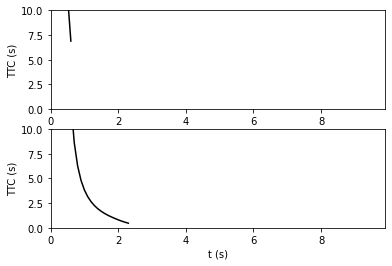

In [28]:
import numpy as np
import importlib
import one_agent_acc_ctrl
importlib.reload(one_agent_acc_ctrl)

x_goal = np.array([10, 10])
x_obstacles = np.array([[5, 4.5], [7, 9]])
one_agent_acc_ctrl.run_simulation(x_goal, x_obstacles)

Just to illustrate what the $C_g$ term does, below the same simulation is run again but with $C_g$ = 0, i.e., no cost for a high required deceleration to be able to stop at the goal. The agent now has no good way of figuring out how to stop at the goal - because the value function only rewards it for keeping a high speed toward the goal, and then all of a sudden punishes it severely for having passed the goal. 

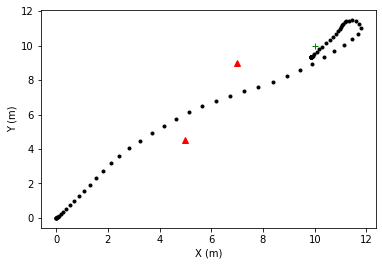

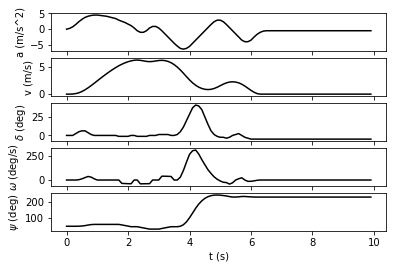

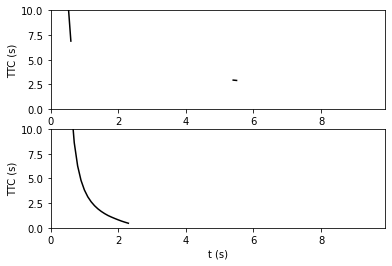

In [29]:
# removing the cost for required deceleration to stop at goal
params = one_agent_acc_ctrl.get_default_params()
params["C_g"] = 0
one_agent_acc_ctrl.run_simulation(x_goal, x_obstacles, params)

Also a test with increased costs for acceleration and steering adjustments, resulting in the agent going around the obstacles instead:

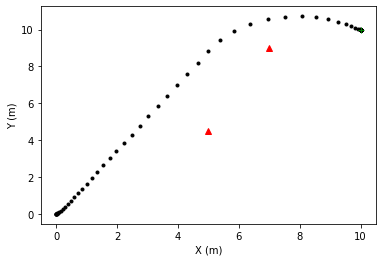

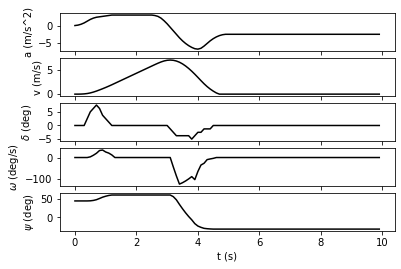

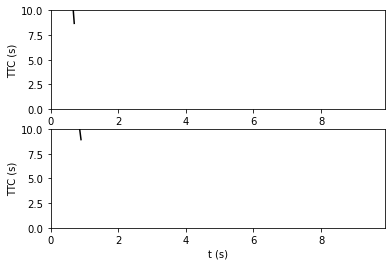

In [30]:
# increasing the control adjustment costs
params = one_agent_acc_ctrl.get_default_params()
params["C_p"] = 1
params["C_t"] = 1
one_agent_acc_ctrl.run_simulation(x_goal, x_obstacles, params)

### Conclusion from the single-agent tests

This seems rather promising - not too difficult to get to work. However, the value function is getting quite complicated, and I think to generalise to a wide range of scenarios we might need additional terms also for dealing properly with the second order yaw acceleration control, e.g., things like "with this control action I won't end up heading toward the goal, but at least my yaw rate will be such that I will be on track to heading toward the goal pretty soon". Or "with this control action I will be heading toward the goal, but I will have a high yaw rate making me quickly head in another direction afterwards". 

Therefore, a good next step will definitely be to simplify to just longitudinal acceleration control, before getting into modelling of two acceleration-controlling agents.


## Two agents controlling longitudinal acceleration

Continuing with two agents now, limited to just longitudinal movement. Building on the OO implementation of two speed-controlling agents in [First simple tests](../first simple tests/First simple test.ipynb). Copy-pasting code, so the code as such is not to be built further on later.

Now the value function is:

$V = k_g v - k_{sc} a_{sc}^2 - k_{sg} a_{sg}^2 - k_{dv} v^2 - k_{da} a^2 - k_e \Delta a^2$

which basically includes all the same types of terms as in the single-agent case, but slightly reordered and relabeled. The terms are, from left to right: value of progress, cost of being on a collision course (now modified to be proportional to the square of the acceleration $a_{sg} = (v / 2 \tau)$ needed to stop before the collision), cost of acceleration required to stop at goal, discomfort costs of high speeds, discomfort costs of large absolute accelerations, and effort costs for acceleration adjustments.

As can be seen below, it is possible to parameterise this model to achieve sensible-looking behaviour, including yielding of the kinematically lagging agent.

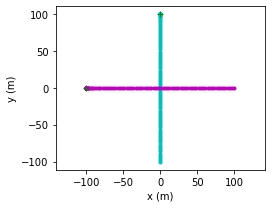

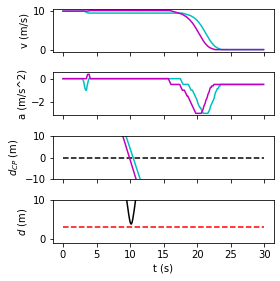

In [31]:
import commotions_acc_ctrl
import multiple_agents_oo_acc_ctrl
import matplotlib.pyplot as plt
import numpy as np

import importlib
importlib.reload(commotions_acc_ctrl)
importlib.reload(multiple_agents_oo_acc_ctrl)

simulation = commotions_acc_ctrl.Simulation(0, 30, 0.1)
agent_A = multiple_agents_oo_acc_ctrl.SimpleAgent( 'A', simulation, initial_state = \
    commotions_acc_ctrl.KinematicState( pos = np.array((0, -101)), yaw_angle = None, long_speed = 10 ), \
    goal = np.array((0, 100)), \
    plot_color = 'c' )
agent_B = multiple_agents_oo_acc_ctrl.SimpleAgent( 'B', simulation, initial_state = \
    commotions_acc_ctrl.KinematicState( pos = np.array((100, 0)), yaw_angle = None, long_speed = 10 ), \
    goal = np.array((-100, 0)), \
    plot_color = 'm' )
simulation.run()
simulation.plot_trajectories()
simulation.plot_time_series()
plt.show()

Instead running the same simulation with both agents starting at zero initial speeds exposes a clear limitation of the assumption that agents judge collision risk by assuming that the other agent maintains constant speed. Since the agents are now at rather low speeds to begin with, they both (including the kinematically lagging agent) judge that it will be easy to accelerate to pass in front of the other agent, and of course they never catch on to the idea that the other agent is doing exactly the same thing, which leads to a collision in the simulation below:

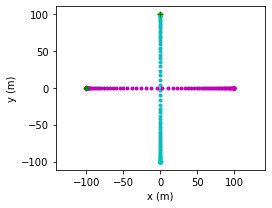

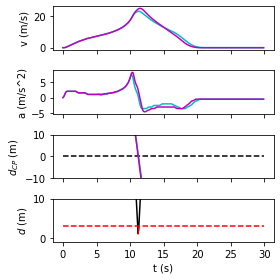

In [32]:
import importlib
importlib.reload(commotions_acc_ctrl)
importlib.reload(multiple_agents_oo_acc_ctrl)

simulation = commotions_acc_ctrl.Simulation(0, 30, 0.1)
agent_A = multiple_agents_oo_acc_ctrl.SimpleAgent( 'A', simulation, initial_state = \
    commotions_acc_ctrl.KinematicState( pos = np.array((0, -101)), yaw_angle = None, long_speed = 0 ), \
    goal = np.array((0, 100)), \
    plot_color = 'c' )
agent_B = multiple_agents_oo_acc_ctrl.SimpleAgent( 'B', simulation, initial_state = \
    commotions_acc_ctrl.KinematicState( pos = np.array((100, 0)), yaw_angle = None, long_speed = 0 ), \
    goal = np.array((-100, 0)), \
    plot_color = 'm' )
simulation.run()
simulation.plot_trajectories()
simulation.plot_time_series()
plt.show()

## Mixing speed-controlling and acceleration-controlling agents

Extending to having one speed-controlling agent (~a pedestrian), and one acceleration-controlling agent (~a car). Copy-pasting code into another file `multiple_agents_oo_mix_ctrl.py` - again this is just for testing now, to figure out how to more nicely expand the code in the root of this repository.

I am using basically the same value function as for the speed-controlling agents in [First simple tests](../first simple tests/First simple test.ipynb), just relabeling the parameters a little bit to be consistent with the notation used in this notebook, and also adding in an effort term for speed change that wasn't in the first simple tests (there I only included an effort term for steering there; adding the speed change effort term here helped get rid of some minor oscillations after the pedestrian reached its goal).

$V = k_g v - k_c / \tau - k_{dv} v^2 - k_e \Delta v^2$

Below it can be seen that rather nice-looking behaviour can be obtained from this mixed-agent model. At sufficiently large initial car distances (here 60 m), the pedestrian just goes ahead and crosses at its free-flowing pace (here 1.5 m/s), but as the initial car distance decreases, the pedestrian will speed up while crossing (2 m/s when car starts 50 m away) to avoid being on a collision course with the car, or yield completely and let the car pass first if the car is too close (here 40 m).

*** Running with initial car distance 60 m ***


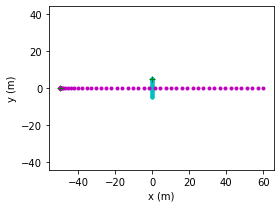

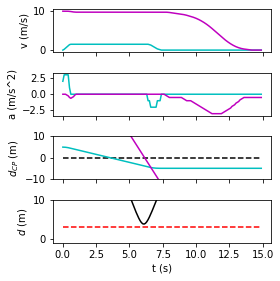

Max pedestrian speed was 1.50 m/s.

*** Running with initial car distance 50 m ***


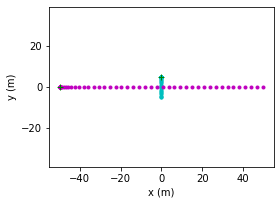

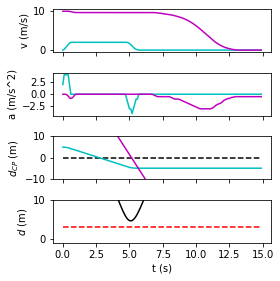

Max pedestrian speed was 2.00 m/s.

*** Running with initial car distance 40 m ***


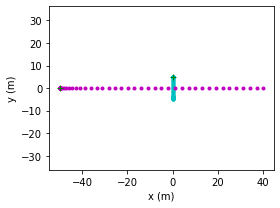

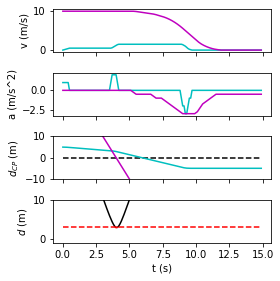

Max pedestrian speed was 1.50 m/s.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import commotions_acc_ctrl
import multiple_agents_oo_mix_ctrl
import importlib
importlib.reload(commotions_acc_ctrl)
importlib.reload(multiple_agents_oo_mix_ctrl)

def run_car_ped_interaction(init_car_distance, ped_k_c = None):
    simulation = commotions_acc_ctrl.Simulation(0, 15, 0.1)
    params_P = multiple_agents_oo_mix_ctrl.SimpleAgentMixCtrl.get_default_parameters(\
        multiple_agents_oo_mix_ctrl.CtrlType.SPEED)
    if not ped_k_c is None:
        params_P.k_c = ped_k_c
    agent_P = multiple_agents_oo_mix_ctrl.SimpleAgentMixCtrl(\
        'P', multiple_agents_oo_mix_ctrl.CtrlType.SPEED, simulation, initial_state = \
        commotions_acc_ctrl.KinematicState( pos = np.array((0, -5)), yaw_angle = None, \
        long_speed = 0 ), goal = np.array((0, 5)), plot_color = 'c', params = params_P )
    agent_C = multiple_agents_oo_mix_ctrl.SimpleAgentMixCtrl(\
        'C', multiple_agents_oo_mix_ctrl.CtrlType.ACCELERATION, simulation, initial_state = \
        commotions_acc_ctrl.KinematicState( pos = np.array((init_car_distance, 0)), yaw_angle = None, \
        long_speed = 10 ), goal = np.array((-50, 0)), plot_color = 'm' )
    print('*** Running with initial car distance %i m ***' % init_car_distance)
    simulation.run() 
    simulation.plot_trajectories()
    simulation.plot_time_series()
    plt.show()
    print('Max pedestrian speed was %.2f m/s.\n' % max(agent_P.trajectory.long_speed))

for car_distance in [60, 50, 40]:
    run_car_ped_interaction(car_distance)

If we decrease the parameter $k_c$ for the pedestrian, making it less concerned about being on a collision course with the car, we can get it to push in front of the car, which prompts some deceleration on the part of the car.

*** Running with initial car distance 40 m ***


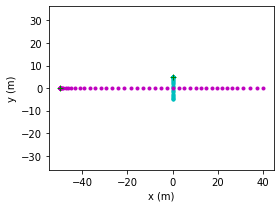

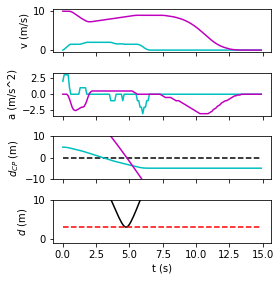

Max pedestrian speed was 2.00 m/s.



In [5]:
run_car_ped_interaction(init_car_distance = 40, ped_k_c = 0.3) # default k_c = 1

# Overall conclusions

Generally this worked better than I would have hoped. The "baseline model" described in the model scoping document can actually achieve quite a lot, it turns out. 

Some limitations:
* The agents always assume constant speed on the part of the other agent, which has a number of implications:
    * As seen above in this notebook, it can cause catastrophic problems especially with two acceleration-controlling agents. 
    * Quite naturally it means that the agents can't do things like recognising that another agent is yielding, or "worry" that a currently stationary agent might suddenly start crossing in front of them. If the car in the 40 m simulation above would have been capable of such worry, it might not have passed the pedestrian at full speed.
* In the simulation above where the pedestrian with reduced $k_c$ walked out in front of the car, the decision was effectively to "accept" a collision (under the agent's assumption that the other vehicle will maintain constant speed). The overall simulation output still looks reasonable given that the car responded with deceleration, and human road users force behaviours from others in this way. But arguably their tendency to do so would be affected by their own affordances for getting out of trouble in the event that the other agent doesn't comply. As an extreme example, consider a 10 m wide car - if that car doesn't decelerate for me after I force myself in front of it, I might not be able to run past it before it reaches me. So maybe the cost for being on a collision course should be affected by the agent's own abilities of getting out of that collision course for example by speeding up. Actually the acceleration-controlling agent already has a collision course cost of this nature in the sense that the cost is in terms of the deceleration required to stop ahead of the collision. This would also encourage agents to move more quickly if putting themselves on a collision course - note that the pedestrian in the reduced-$k_c$ simulation above started crossing at it's free flowing speed of 1.5 m/s, only increasing to 2 m/s once the car started coming a bit more uncomfortably close.